In [2]:
using  Languages, TextAnalysis, Flux, PyPlot, Statistics, Embeddings

In [3]:
# Array of documents for data (example)
# Input directory given by the user

doc_array = ["well done",
     "good work",
     "great effort",
     "nice work",
     "excellent",
     "weak",
     "poor effort",
     "not good",
     "poor work",
     "could have done better"]


10-element Array{String,1}:
 "well done"             
 "good work"             
 "great effort"          
 "nice work"             
 "excellent"             
 "weak"                  
 "poor effort"           
 "not good"              
 "poor work"             
 "could have done better"

In [4]:
# positve or negative sentiment to each 'document' string
# labels can be loaded from a file given by the user

y = [true true true true true false false false false false]


1×10 Array{Bool,2}:
 1  1  1  1  1  0  0  0  0  0

In [5]:
# pushing the text from the files to the string documents
docs=[]
for i in 1:length(doc_array)
    push!(docs, StringDocument(doc_array[i]))
end


In [6]:
# building a Corpus
corpus=Corpus(docs)

# updating the lexicon and creating the word dict
update_lexicon!(corpus)
doc_term_matrix=DocumentTermMatrix(corpus)
word_dict=doc_term_matrix.column_indices

# function to return the index of the word in the word dictionary
tk_idx(s) = haskey(word_dict, s) ? i=word_dict[s] : i=0


tk_idx (generic function with 1 method)

In [7]:
# Padding the corpus wrt the longest document
function pad_corpus(c, pad_size)
    M=[]
    for doc in 1:length(c)
        tks = tokens(c[doc])
        if length(tks)>=pad_size
            tk_indexes=[tk_idx(w) for w in tks[1:pad_size]]
        end
        if length(tks)<pad_size
            tk_indexes=zeros(Int64,pad_size-length(tks))
            tk_indexes=vcat(tk_indexes, [tk_idx(w) for w in tks])
        end
        doc==1 ? M=tk_indexes' : M=vcat(M, tk_indexes')
    end
    return M
end



pad_corpus (generic function with 1 method)

In [8]:
# splitting words in the document
word_docs = map(split,doc_array)
# pad size is the number of words in the maximum word document
pad_size = maximum(length(word_docs[i]) for i in 1:length(doc_array))
# padding the docs
padded_docs = pad_corpus(corpus, pad_size)
# forming the data with the labels
x = padded_docs'
data = [(x, y)]


1-element Array{Tuple{LinearAlgebra.Adjoint{Int64,Array{Int64,2}},Array{Bool,2}},1}:
 ([0 0 … 0 2; 0 0 … 0 8; 13 6 … 11 3; 3 14 … 14 1], [1 1 … 0 0])

In [27]:
function vec_idx(s)
    i=findfirst(x -> x==s, vocab)
    i==nothing ? i=0 : i 
end

In [28]:
const embtable = load_embeddings(GloVe{:en},1) # or load_embeddings(FastText_Text) or ...
#Function to return the index of the word in the embedding (returns 0 if the word is not found)
const get_word_index = Dict(word=>ii for (ii,word) in enumerate(embtable.vocab))

function get_embedding(word)
    ind = get_word_index[word]
    emb = embtable.embeddings[:,ind]
    return emb
end

get_embedding (generic function with 1 method)

In [29]:
embeddings = embtable.embeddings
vocab = embtable.vocab
embed_size, max_features = size(embeddings)

(50, 400000)

In [33]:
# Building Flux Embeddings
N = size(padded_docs,1)  #Number of documents
max_features = 50
# number of words in the vocabulary, should always be higher than the maximum index in our dictionary.
vocab_size = 20


20

In [34]:
max_features

50

In [35]:
# Embedding layer for Flux model
# glorot_normal returns an Array of size dims containing random variables taken from a normal distribution with mean 0 and standard deviation (2 / sum(dims)).
embedding_matrix=Flux.glorot_normal(max_features, vocab_size)

for term in doc_term_matrix.terms
    if vec_idx(term)!=0
        embedding_matrix[:,word_dict[term]+1]=get_embedding(term)
    end
end 

In [36]:
# Enabling Flux

m = Chain(x -> embedding_matrix * Flux.onehotbatch(reshape(x, pad_size*N), 0:vocab_size-1),
          x -> reshape(x, max_features, pad_size, N),
          x -> sum(x, dims=2),
          x -> reshape(x, max_features, N),
          Dense(max_features, 1, σ)
)

Chain(#17, #18, #19, #20, Dense(50, 1, σ))

Layer 1. As x is fed into the model, the first layer’s embedding function matches the words in each document to corresponding word vectors. This is done by rolling all the word vectors one after the other and using onehotbatch to filter out the unwanted words. The output is a 8x40 array (W\[8x20\]\*onehotbatch\[20x40\]).

Layer 2. Unrolls the vectors into the shape 8x4x10; i.e. 8 features and 10 documents of padded size 4.

Layer 3. Now that our data is in the shape provided by layer 2 we can sum the word vectors to get an overall ‘meaning’ vector for each document. The output is now in the shape size of 8 x 1 x 10.

Layer 4: Drops an axis so that the shape of x is a size suitable for training. After this step the shape is 8x10.

Layer 5: is a normal Dense layer with the sigmoid activation function to give us nice probabilities.

If you’d like to see each layer in action I recommend using m\[1\](x) to see sample output from the first layer. m\[1:2\](x) to see output from the second layer and so on.

## Breaking the model

In [37]:
x

4×10 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
  0   0  0   0  0   0   0   0   0  2
  0   0  0   0  0   0   0   0   0  8
 13   6  7   9  0   0  11  10  11  3
  3  14  4  14  5  12   4   6  14  1

In [38]:
reshape(x,pad_size*N)

40-element reshape(::LinearAlgebra.Adjoint{Int64,Array{Int64,2}}, 40) with eltype Int64:
  0
  0
 13
  3
  0
  0
  6
 14
  0
  0
  7
  4
  0
  ⋮
  0
  0
 10
  6
  0
  0
 11
 14
  2
  8
  3
  1

In [39]:
Flux.onehotbatch(reshape(x, pad_size*N), 0:vocab_size-1)
# One hot encoded matrix has 1s on the positions of the vocab index (Eg 0 0 13 3 for first word vector)
# All the vectors are placed side by side concatenated

20×40 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 1  1  0  0  1  1  0  0  1  1  0  0  1  …  1  1  0  0  1  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0

In [44]:
loss_h=[]
accuracy_train=[]
accuracy(x, y) = mean(x .== y)
loss(x, y) = sum(Flux.binarycrossentropy.(m(x), y))
optimizer = Flux.Descent(0.01)

Descent(0.01)

In [45]:
for epoch in 1:400
    Flux.train!(loss, Flux.params(m), data, optimizer)
    println(loss(x, y), " ", accuracy(m(x).>0.5,y))
    push!(loss_h, loss(x, y))
    push!(accuracy_train, accuracy(m(x).>0.5,y))
end
println(m(x).>0.5)
accuracy(m(x).>0.5,y)

8.477022 0.4
7.433271 0.6
6.7485995 0.4
6.1744123 0.6
5.6852417 0.6
5.261686 0.6
4.893052 0.7
4.5708785 0.8
4.288175 0.8
4.038999 0.9
3.8183239 0.9
3.6219194 0.9
3.446241 1.0
3.2883253 1.0
3.145696 1.0
3.0162797 1.0
2.8983374 1.0
2.7904053 1.0
2.6912456 1.0
2.5998104 1.0
2.5152059 1.0
2.436668 1.0
2.3635402 1.0
2.295256 1.0
2.2313247 1.0
2.1713204 1.0
2.1148689 1.0
2.061645 1.0
2.0113606 1.0
1.9637619 1.0
1.9186236 1.0
1.8757467 1.0
1.8349513 1.0
1.796079 1.0
1.7589859 1.0
1.7235436 1.0
1.6896348 1.0
1.6571554 1.0
1.6260089 1.0
1.5961094 1.0
1.5673769 1.0
1.5397395 1.0
1.5131315 1.0
1.4874914 1.0
1.4627638 1.0
1.4388969 1.0
1.4158437 1.0
1.3935599 1.0
1.372006 1.0
1.3511434 1.0
1.3309369 1.0
1.3113552 1.0
1.2923667 1.0
1.2739435 1.0
1.2560595 1.0
1.23869 1.0
1.221812 1.0
1.205403 1.0
1.1894431 1.0
1.1739131 1.0
1.1587954 1.0
1.1440723 1.0
1.1297278 1.0
1.1157477 1.0
1.1021167 1.0
1.0888216 1.0
1.0758497 1.0
1.0631886 1.0
1.0508268 1.0
1.0387541 1.0
1.0269595 1.0
1.0154331 1.0
1.0041659

1.0

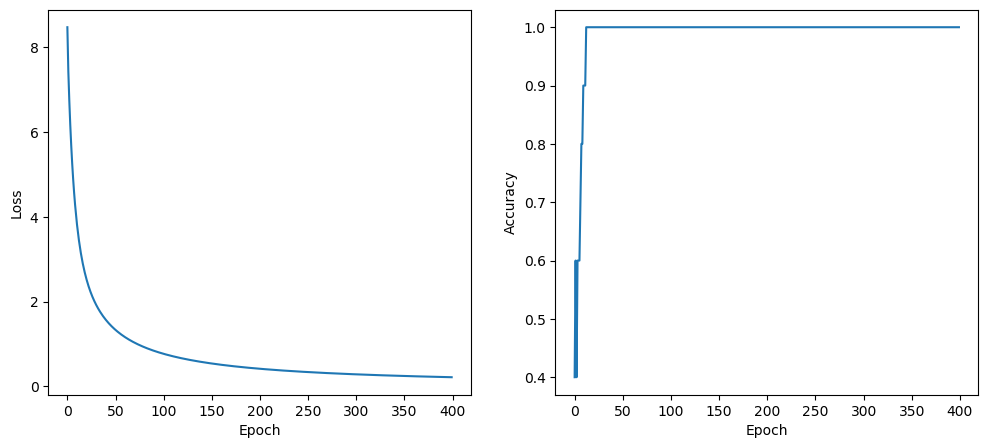

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x194fd9490>

In [46]:
figure(figsize=(12,5))
subplot(121)
PyPlot.xlabel("Epoch")
ylabel("Loss")
plot(loss_h)

subplot(122)
PyPlot.xlabel("Epoch")
ylabel("Accuracy")
plot(accuracy_train, label="train")